# Imports

In [17]:
import os
import glob
import json
import ast
import re

from typing import Dict, List

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

# Utils

In [18]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

get_metabolite_info()

def rename(name: str):
    name = name.removeprefix('param_regressor__')
    name = name.removesuffix('_test_score')
    return name

def fmt_param(param: str):
    if type(param) == float:
        return "-"
    param = param.replace('{', '').replace('}', '').replace('regressor__regressor__', '').replace("\'", '')
    param = param.split(',')[1:]
    param = [param.strip() for param in param if "=" not in param]
    return '\n'.join(param)

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def fmt_regressor(df: pd.DataFrame):
    df['regressor'] = df['regressor'].replace(to_replace=r'^DecisionTreeRegressor.*', value="DecisionTreeRegressor()", regex=True)
    df['regressor'] = df['regressor'].replace(to_replace=r'^ElasticNet.*', value="ElasticNet()", regex=True)
    df['regressor'] = df['regressor'].replace(to_replace=r'^SVR.*', value="SVR()", regex=True)
    return df

def fmt_cv_results(df: pd.DataFrame):
    
    df.columns = df.columns.map(lambda name: rename(name))
    df = fmt_regressor(df)
    df['mean'] = -1 * df['mean']
    df['std'] = -1 * df['std']
    

    df['params_fmt'] = df['params'].map(lambda param: fmt_param(param))
    df = df[df['params_fmt'] != "-"]
    # filter depth none 
    df = df[(df['regressor'] == 'DecisionTreeRegressor()') & (df['regressor__max_depth'] > 0) | (df['regressor'] != 'DecisionTreeRegressor()')]
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

In [19]:
metabolite_info = get_metabolite_info()

# Experiments

## Experiment base (TIER0)

### Strategy all

In [20]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"
paths = glob.glob(dir + "/S*.csv")
paths

['/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_oaa.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_r5p.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_dhap.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.ALL_all.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_akg.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_g6p;g6p-B.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_pyr.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_g6p;f6p;g6p-B.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE

In [21]:
df = pd.read_csv(f'{dir}/Strategy.ALL_all.csv')
df = fmt_cv_results(df)
df

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,pca__n_components,preprocessor__num__scaler,regressor,regressor__kernel,regressor__criterion,...,split4,split5,split6,split7,split8,split9,mean,std,rank,params_fmt
0,0,0.068739,0.005122,0.009679,0.002160,10,MinMaxScaler(),SVR(),linear,NaN,...,-0.464348,-0.376963,-0.444036,-0.405681,-0.516300,-0.328014,0.417937,-0.069646,348,regressor__preprocessor__num__scaler: MinMaxSc...
1,1,0.047014,0.004941,0.009488,0.000958,10,MinMaxScaler(),SVR(),poly,NaN,...,-0.357034,-0.387134,-0.386149,-0.332671,-0.453783,-0.287257,0.365882,-0.060065,247,regressor__preprocessor__num__scaler: MinMaxSc...
2,2,0.038480,0.003866,0.009902,0.001891,10,MinMaxScaler(),SVR(),rbf,NaN,...,-0.381451,-0.378007,-0.356643,-0.310283,-0.439418,-0.274595,0.353867,-0.057288,178,regressor__preprocessor__num__scaler: MinMaxSc...
3,3,0.043771,0.001817,0.008367,0.001470,10,MinMaxScaler(),SVR(),sigmoid,NaN,...,-3.723827,-2.675122,-2.460736,-2.772619,-3.032428,-3.303679,2.980820,-0.438151,508,regressor__preprocessor__num__scaler: MinMaxSc...
4,4,0.526801,0.081673,0.007955,0.001247,10,StandardScaler(),SVR(),linear,NaN,...,-0.465728,-0.378602,-0.440505,-0.403733,-0.513780,-0.325452,0.415617,-0.069371,347,regressor__preprocessor__num__scaler: Standard...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,505,0.165326,0.024743,0.008136,0.002566,100,RobustScaler(),ElasticNet(),NaN,NaN,...,-0.393314,-0.351533,-0.329151,-0.358336,-0.421959,-0.289793,0.356780,-0.047991,191,regressor__preprocessor__num__scaler: RobustSc...
506,506,0.156692,0.013316,0.007861,0.001967,100,RobustScaler(),ElasticNet(),NaN,NaN,...,-0.461878,-0.372358,-0.442983,-0.446400,-0.528261,-0.378438,0.441372,-0.065331,377,regressor__preprocessor__num__scaler: RobustSc...
507,507,0.169236,0.019114,0.008729,0.001716,100,RobustScaler(),ElasticNet(),NaN,NaN,...,-0.456221,-0.402133,-0.471800,-0.466567,-0.556626,-0.405892,0.463953,-0.062892,391,regressor__preprocessor__num__scaler: RobustSc...
508,508,0.171489,0.009209,0.009176,0.002021,100,RobustScaler(),ElasticNet(),NaN,NaN,...,-0.450963,-0.415855,-0.481931,-0.477330,-0.565553,-0.417509,0.474115,-0.062277,416,regressor__preprocessor__num__scaler: RobustSc...


In [22]:
test_df = pd.read_csv(
    f'{dir}/best_model_performance_Strategy.ALL.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
test_df

,metabolite_id,r2,official_name,kegg_id,pathway,method,Order
0,pyr,0.724827,Pyruvate,C00022,Glycolysis,TCA,8
0,r5p,0.746712,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
0,pep,0.769951,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7
0,3pg;2pg,0.838729,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11
0,dhap,0.887054,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
0,f6p,0.864401,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
0,g6p;f6p;g6p-B,0.398579,D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10
0,accoa,0.629012,Acetyl-CoA,C00024,TCA,TCA,1
0,g6p;g6p-B,0.811821,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
0,akg,-0.258318,2-Oxoglutarate,C00026,TCA,TCA,4


In [23]:
test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance_Strategy.ALL.json'
)
test_pred_df = test_pred_df.T.reset_index().set_axis(['metabolite_id', 'y_true', 'y_pred'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])
test_pred_df

,metabolite_id,y_true,y_pred,official_name,kegg_id,pathway,method,Order
1,pyr,0.464969,0.650694,Pyruvate,C00022,Glycolysis,TCA,8
1,pyr,1.096708,0.650694,Pyruvate,C00022,Glycolysis,TCA,8
1,pyr,0.729733,0.650694,Pyruvate,C00022,Glycolysis,TCA,8
1,pyr,0.896245,0.650694,Pyruvate,C00022,Glycolysis,TCA,8
1,pyr,0.881808,-0.305673,Pyruvate,C00022,Glycolysis,TCA,8
...,...,...,...,...,...,...,...,...
11,oaa,0.075601,-0.305673,Oxaloacetate,C00036,TCA,TCA,8
11,oaa,0.112654,0.650694,Oxaloacetate,C00036,TCA,TCA,8
11,oaa,0.191636,-0.338017,Oxaloacetate,C00036,TCA,TCA,8
11,oaa,-0.006942,-0.305673,Oxaloacetate,C00036,TCA,TCA,8


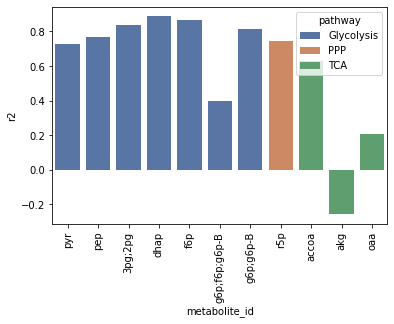

In [24]:
_df = test_df.sort_values('pathway')
g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='r2',
    hue='pathway',
    dodge=False,
    palette='deep',
)
# g.set(yscale='symlog')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

(-1.5, 1.5)

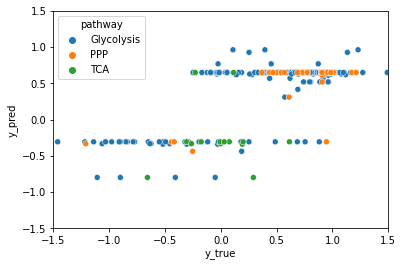

In [25]:
_df = test_pred_df.sort_values('pathway')
g = sns.scatterplot(
    data=_df,
    x='y_true',
    y='y_pred',
    hue='pathway',
)

g.axes.set_xlim([-1.5, 1.5])
g.axes.set_ylim([-1.5, 1.5])

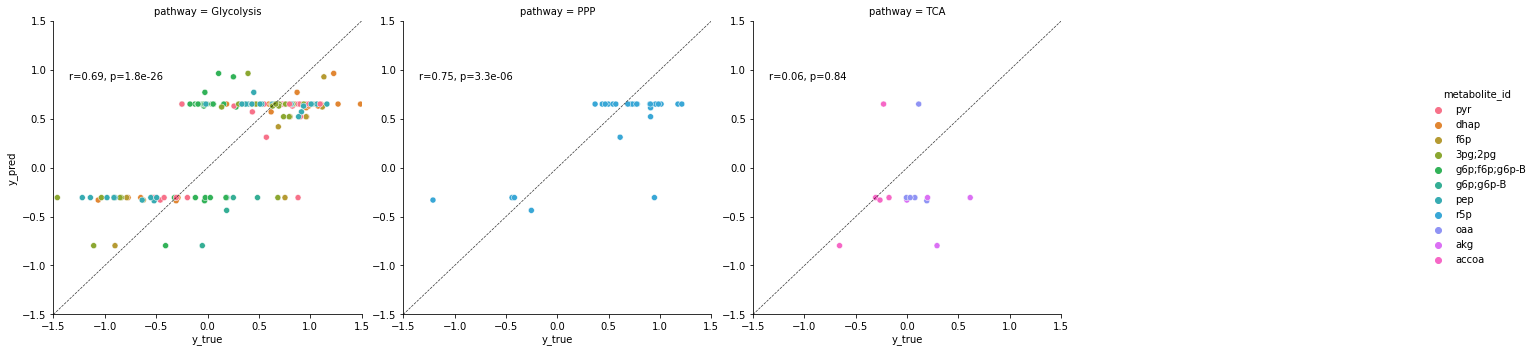

In [26]:
_df = test_pred_df.sort_values('pathway')
rel = sns.relplot(
    data=_df,
    x="y_true",
    y="y_pred",
    kind="scatter",
    col="pathway",
    hue='metabolite_id',
    col_wrap=4,
    facet_kws={'sharey': False, 'sharex': False}
)
axes_limits = np.array([-1.5, 1.5])

for ax in rel.fig.axes:
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])

for ax in rel.fig.axes:
    ax.plot(axes_limits, axes_limits, ls='--', c='black', alpha=0.8, lw=0.7)

for ax, pathway in zip(rel.fig.axes, _df['pathway'].unique()):
    _cdf = _df[_df['pathway'] == pathway]
    r, p = pearsonr(_cdf['y_true'], _cdf['y_pred'])
    ax.text(
        .05, .8, 
        f'r={r:.2f}, p={p:.2g}',
        transform=ax.transAxes
    )

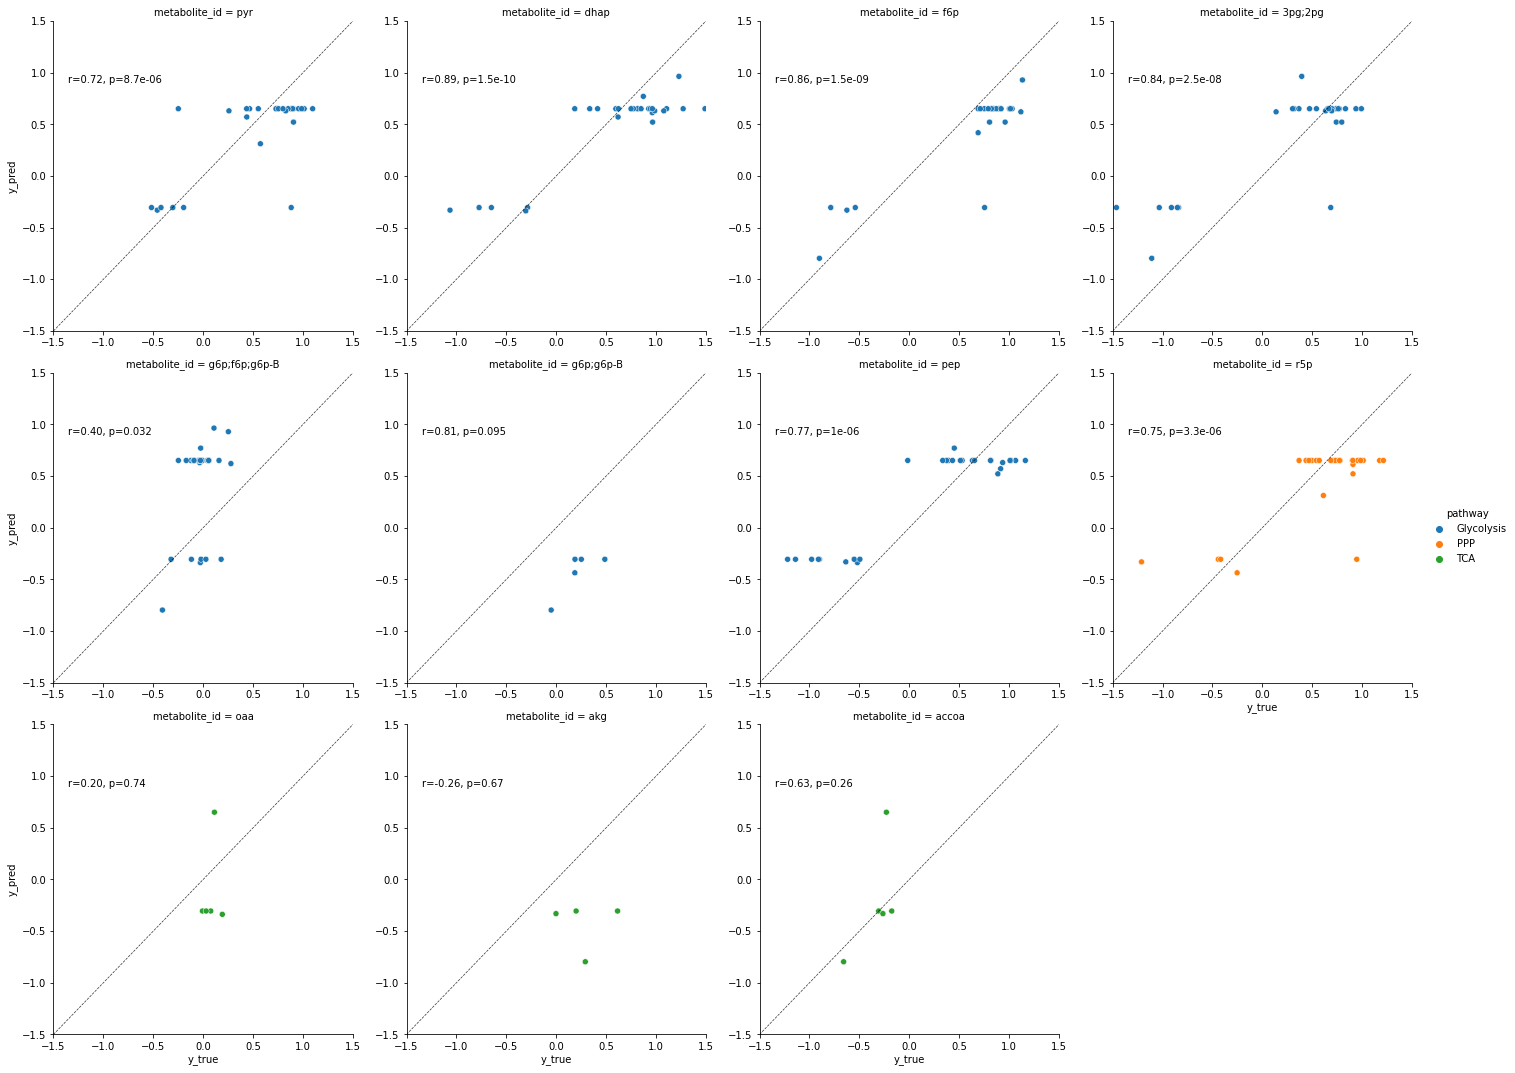

In [27]:
_df = test_pred_df.sort_values('pathway')
rel = sns.relplot(
    data=_df,
    x="y_true",
    y="y_pred",
    kind="scatter",
    col="metabolite_id",
    hue='pathway',
    col_wrap=4,
    facet_kws={'sharey': False, 'sharex': False}
)
axes_limits = np.array([-1.5, 1.5])

for ax in rel.fig.axes:
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])

for ax in rel.fig.axes:
    ax.plot(axes_limits, axes_limits, ls='--', c='black', alpha=0.8, lw=0.7)

for ax, metabolite_id in zip(rel.fig.axes, _df['metabolite_id'].unique()):
    _cdf = _df[_df['metabolite_id'] == metabolite_id]
    r, p = pearsonr(_cdf['y_true'], _cdf['y_pred'])
    ax.text(
        .05, .8, 
        f'r={r:.2f}, p={p:.2g}',
        transform=ax.transAxes
    )

### Strategy metabolic

In [29]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0"
paths = glob.glob(dir + "/Strategy.METABOLITE_CENTRIC*.csv")
paths

['/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_oaa.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_r5p.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_dhap.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_akg.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_g6p;g6p-B.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_pyr.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_g6p;f6p;g6p-B.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Strategy.METABOLITE_CENTRIC_f6p.csv',
 '/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_0/Stra

In [30]:
df = gather_results(paths)
df = fmt_cv_results(df)
df = combine_metabolite_info(df)
df[['regressor', 'params_fmt', 'mean', 'metabolite_id']]

,regressor,params_fmt,mean,metabolite_id
0,SVR(),regressor__preprocessor__num__scaler: MinMaxSc...,0.216569,oaa
1,SVR(),regressor__preprocessor__num__scaler: MinMaxSc...,0.200695,oaa
2,SVR(),regressor__preprocessor__num__scaler: MinMaxSc...,0.244373,oaa
3,SVR(),regressor__preprocessor__num__scaler: MinMaxSc...,0.371308,oaa
4,SVR(),regressor__preprocessor__num__scaler: Standard...,0.206713,oaa
...,...,...,...,...
250,ElasticNet(),regressor__preprocessor__num__scaler: RobustSc...,0.144866,accoa
251,ElasticNet(),regressor__preprocessor__num__scaler: RobustSc...,0.116848,accoa
252,ElasticNet(),regressor__preprocessor__num__scaler: RobustSc...,0.098451,accoa
253,ElasticNet(),regressor__preprocessor__num__scaler: RobustSc...,0.095131,accoa


(660, 34)
(1320, 34)
(825, 34)


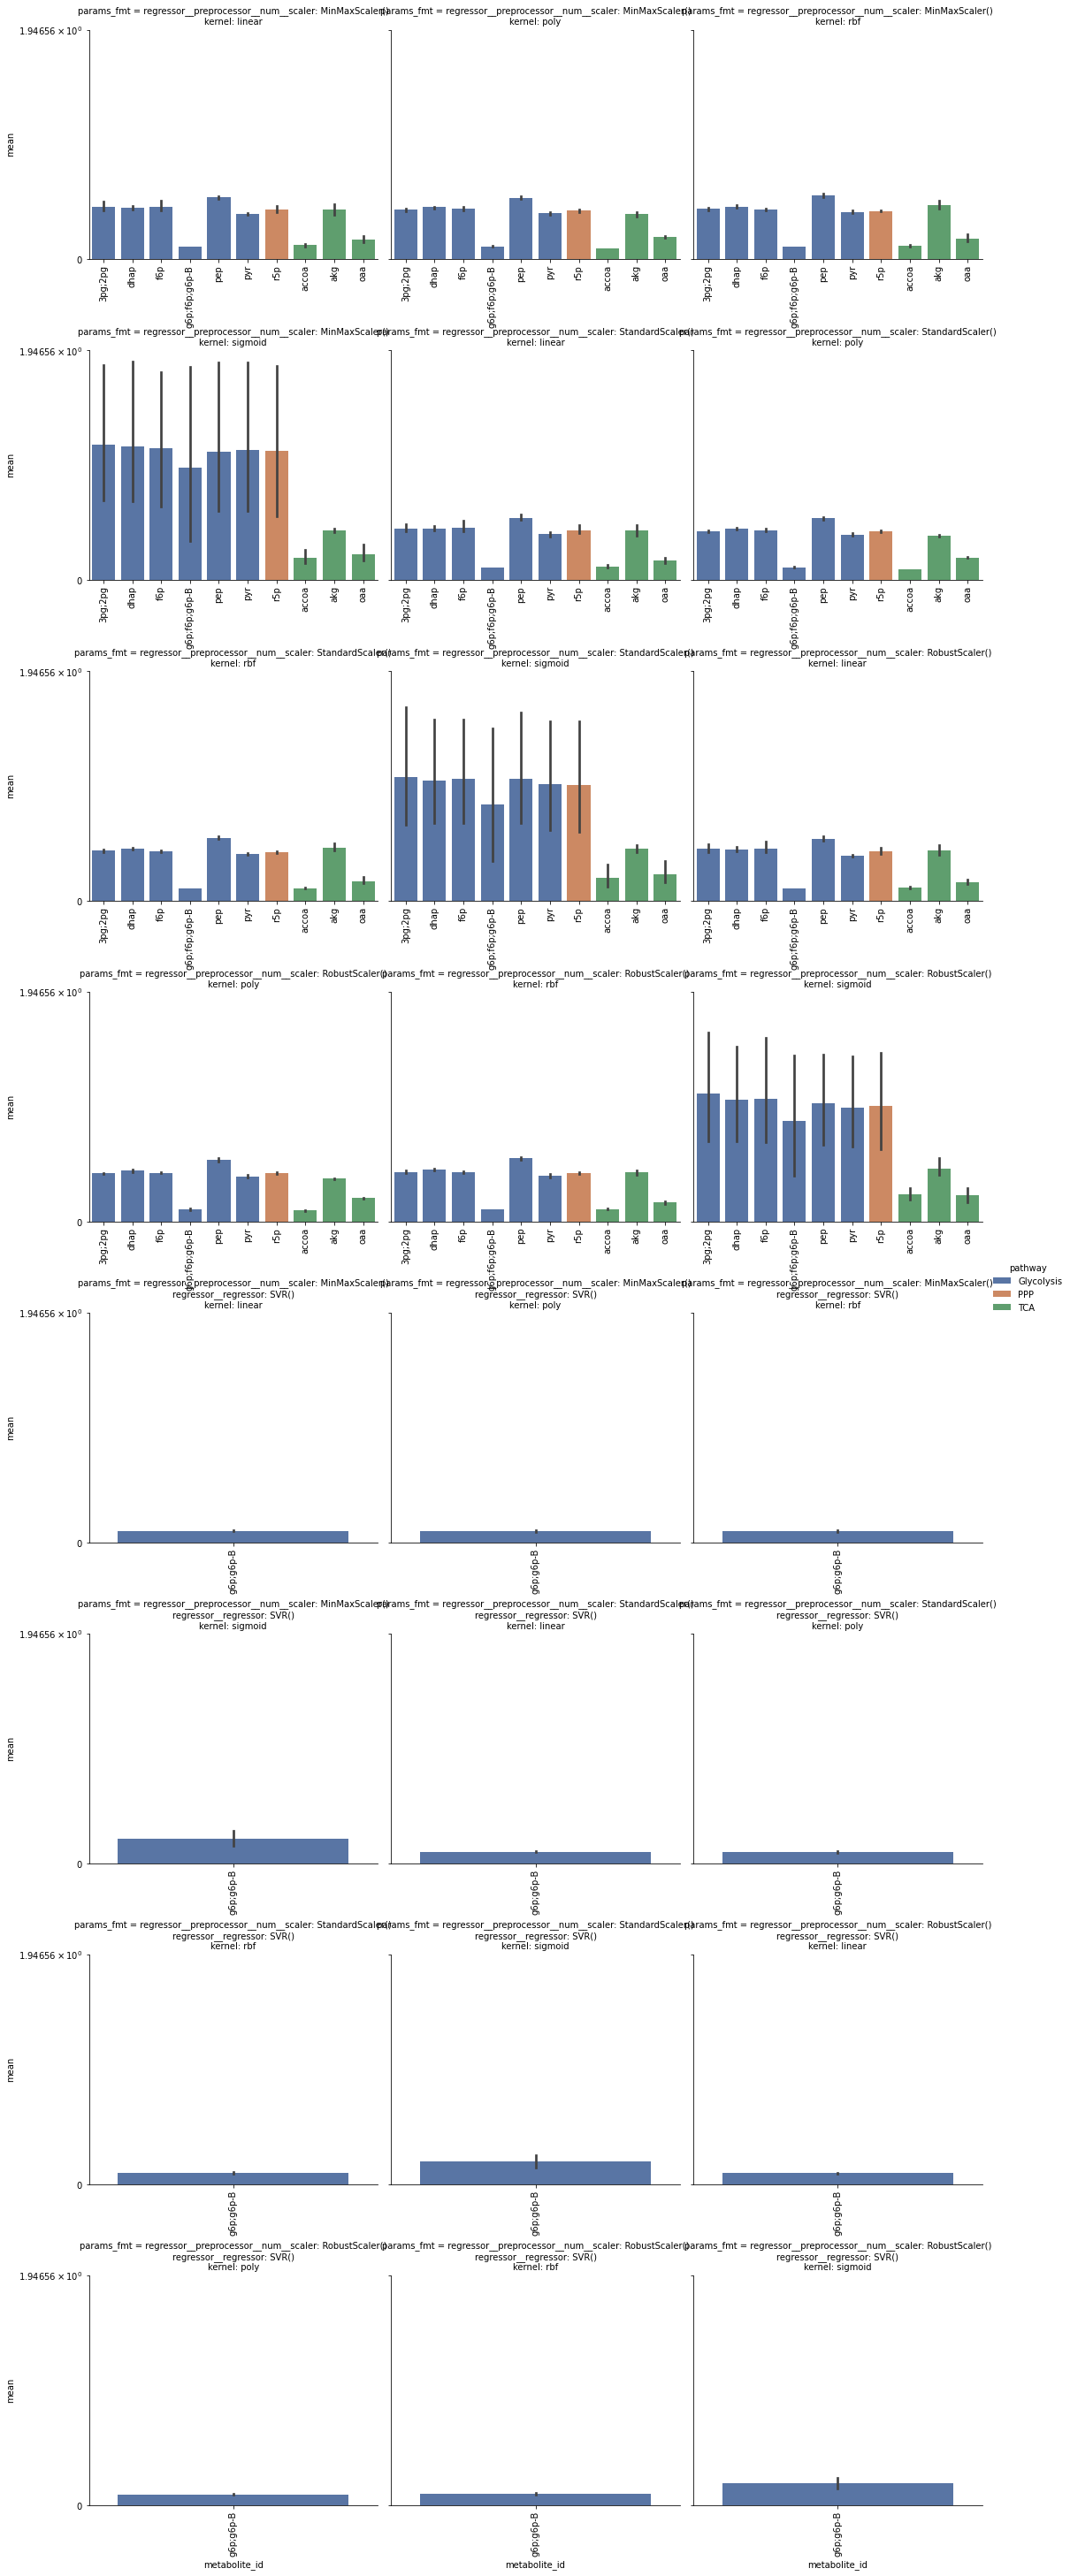

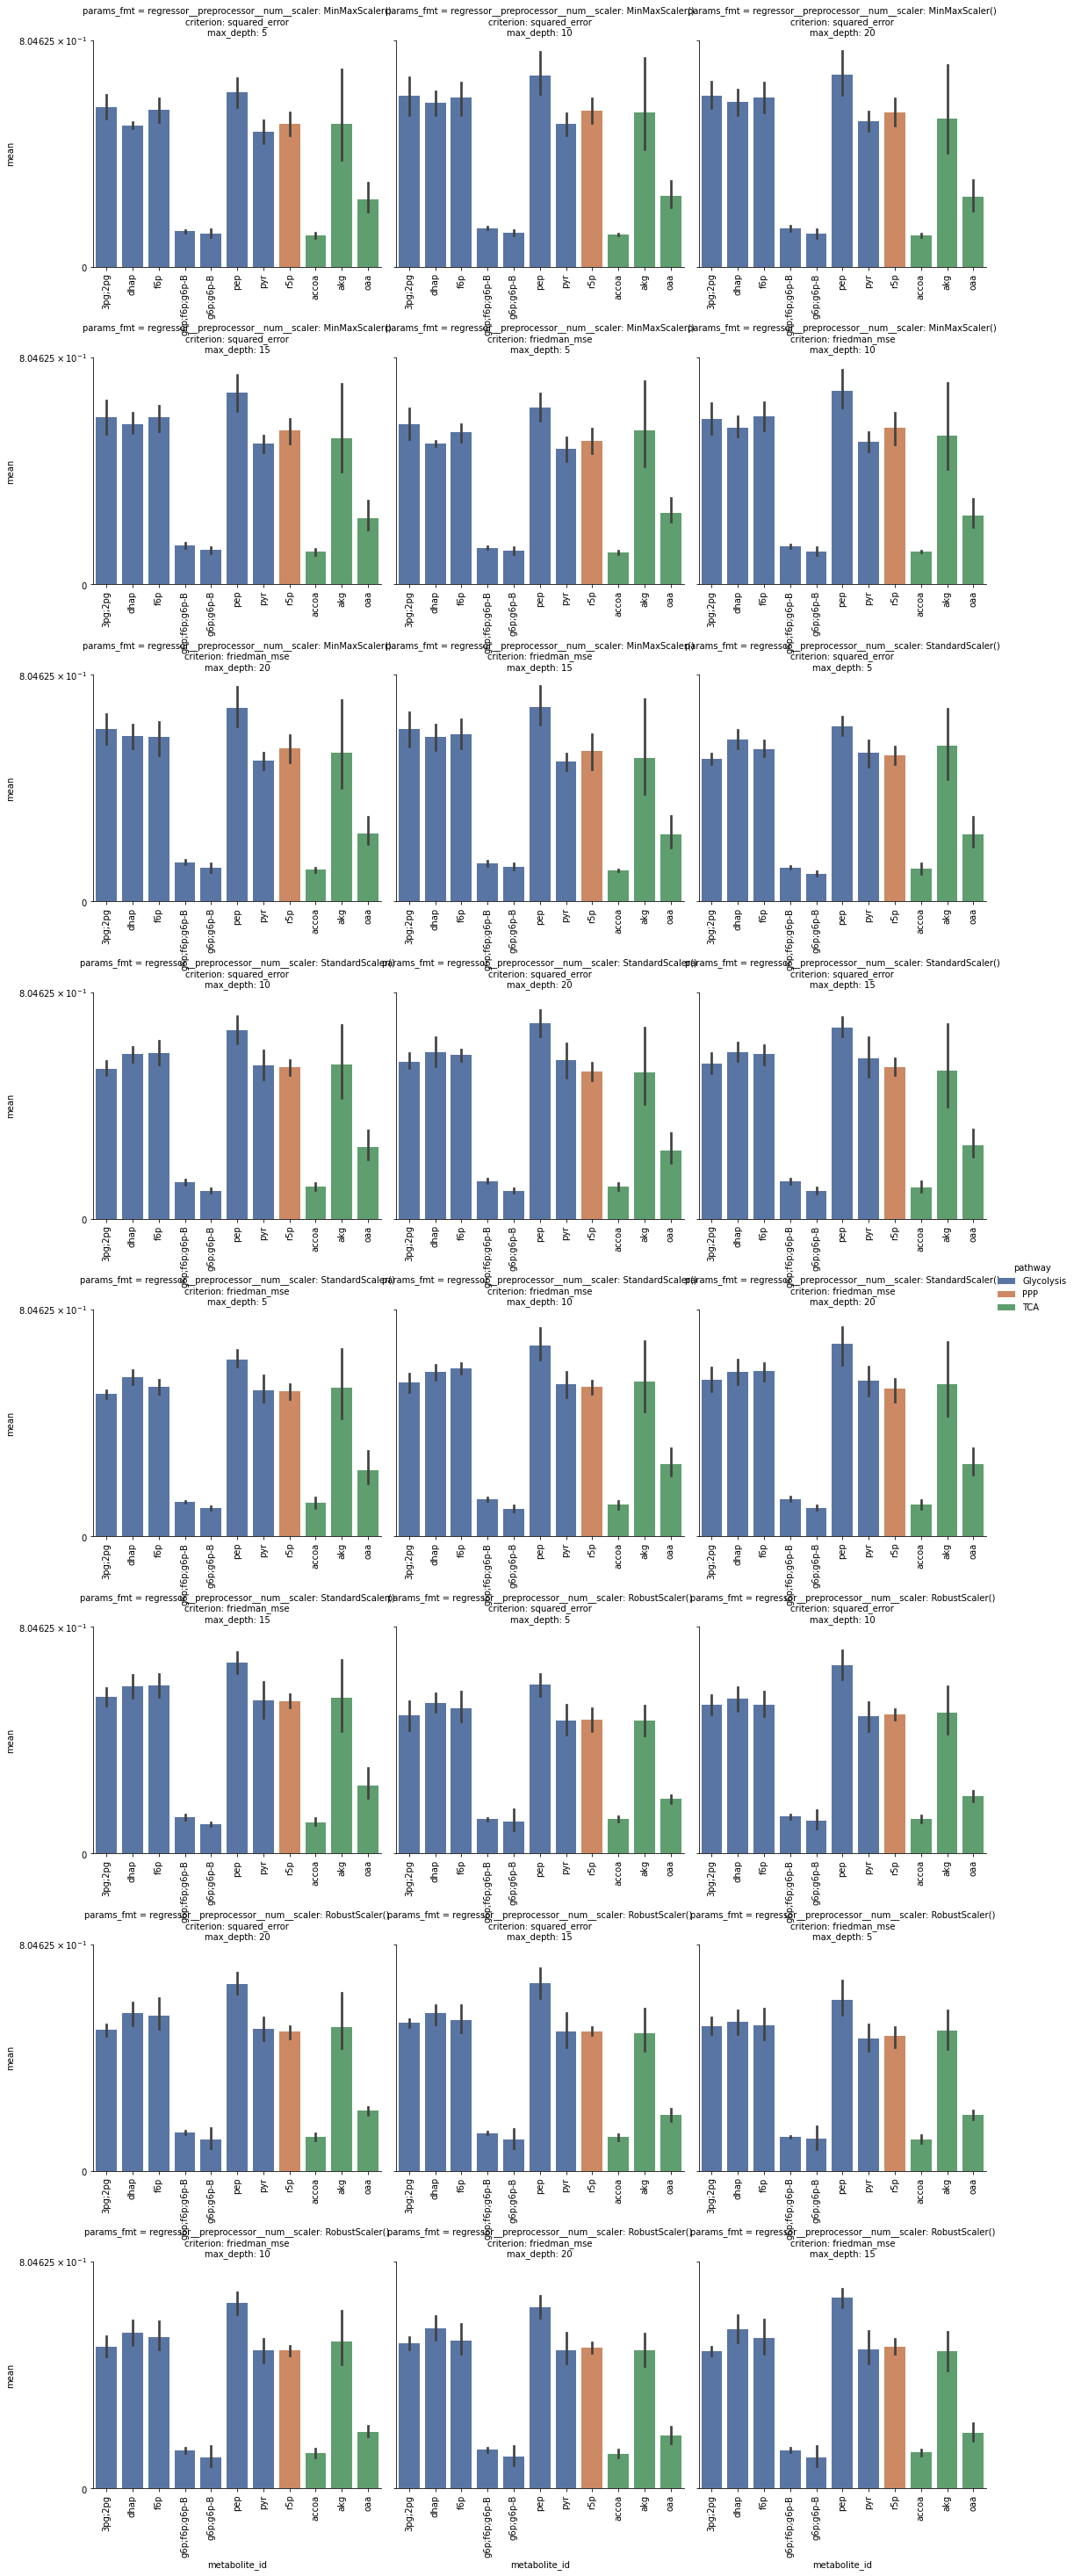

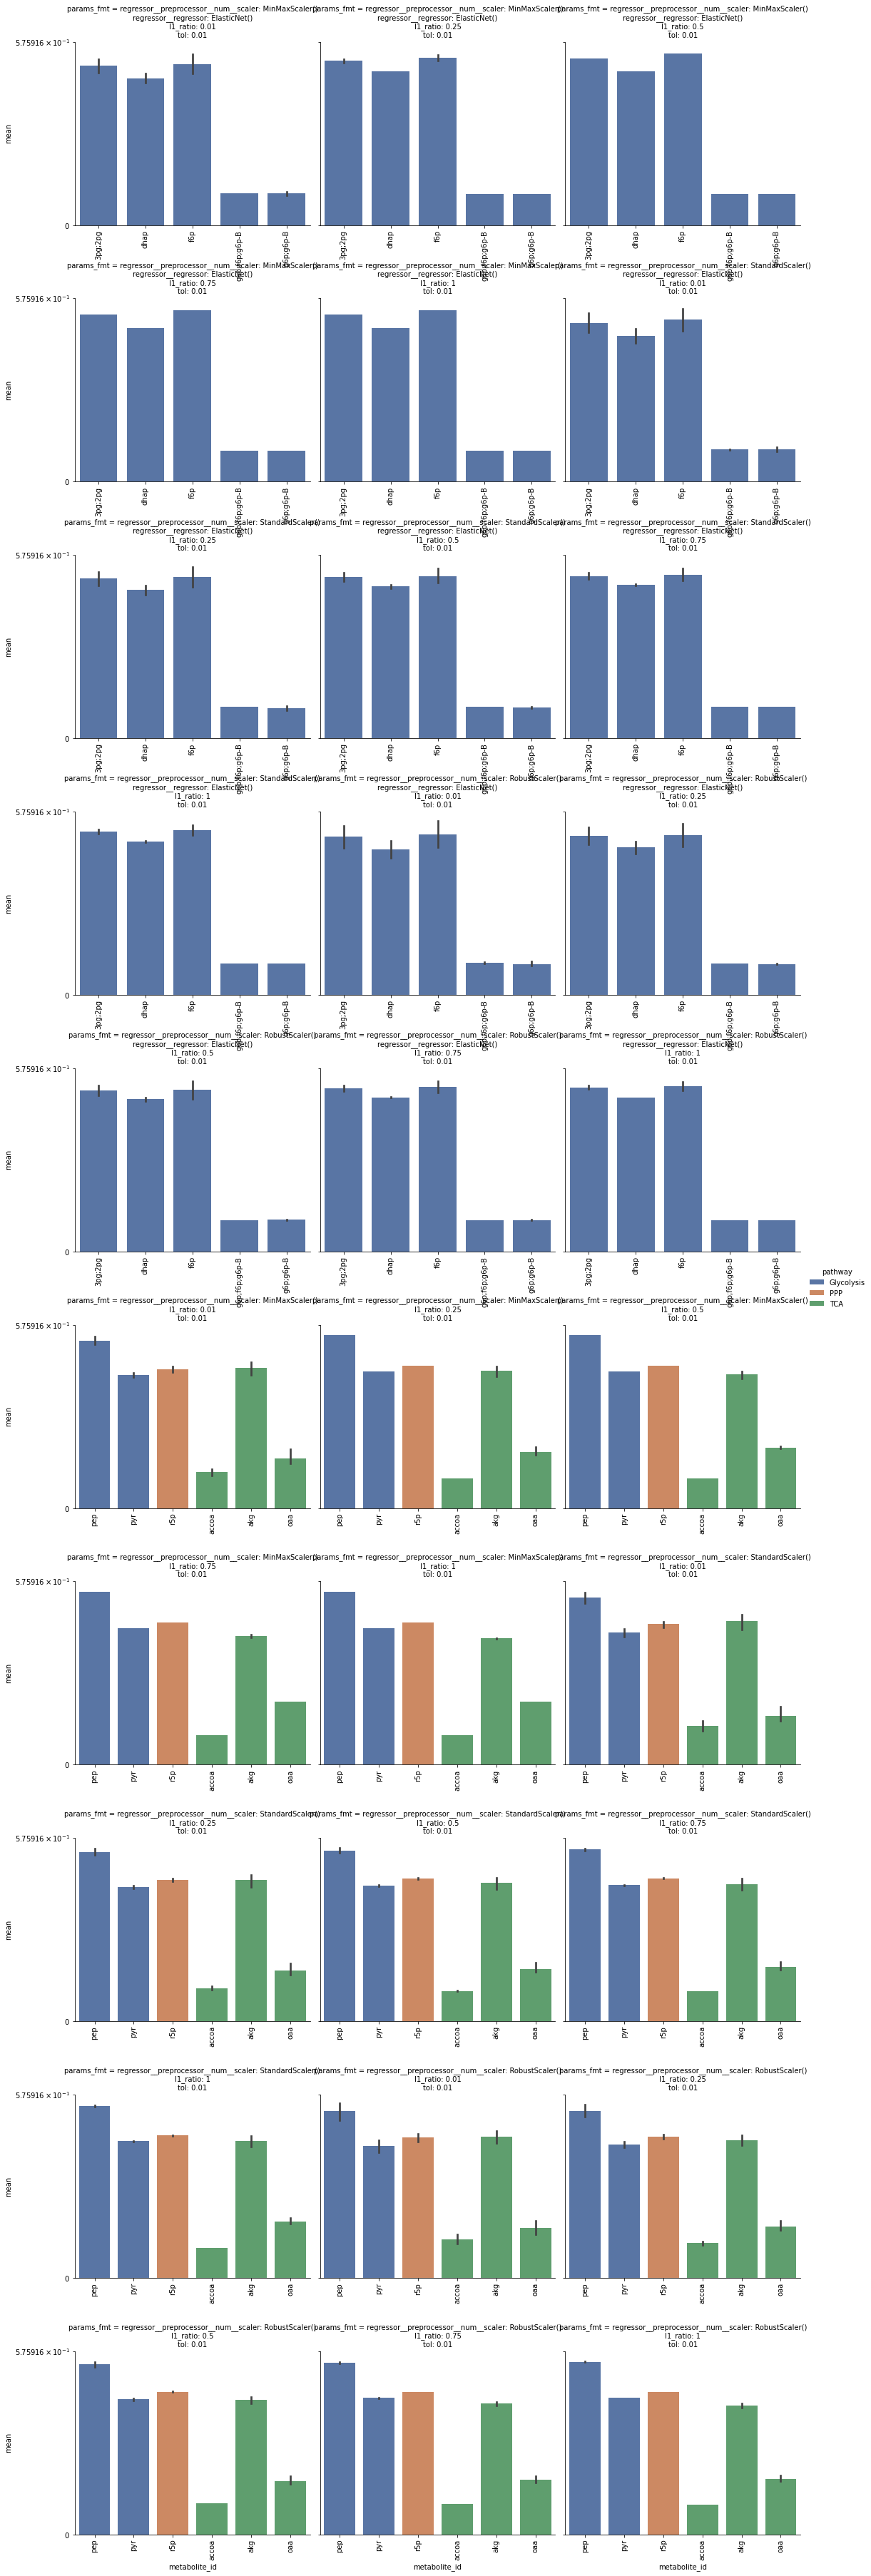

In [31]:
for reggressor in df['regressor'].unique():
    _df = df[df['regressor'] == reggressor].sort_values(['pathway', 'metabolite_id'])
    print(_df.shape)
    g = sns.catplot(
        x='metabolite_id',
        y='mean',
        hue='pathway',
        col='params_fmt',
        col_wrap=3,
        sharey=True,
        sharex=False,
        kind='bar',
        data=_df,
        dodge=False,
        palette='deep',
        # legend=False,
    )

    g.set(yscale='symlog')
    g.set_xticklabels(rotation=90)
    plt.subplots_adjust(hspace=0.4)

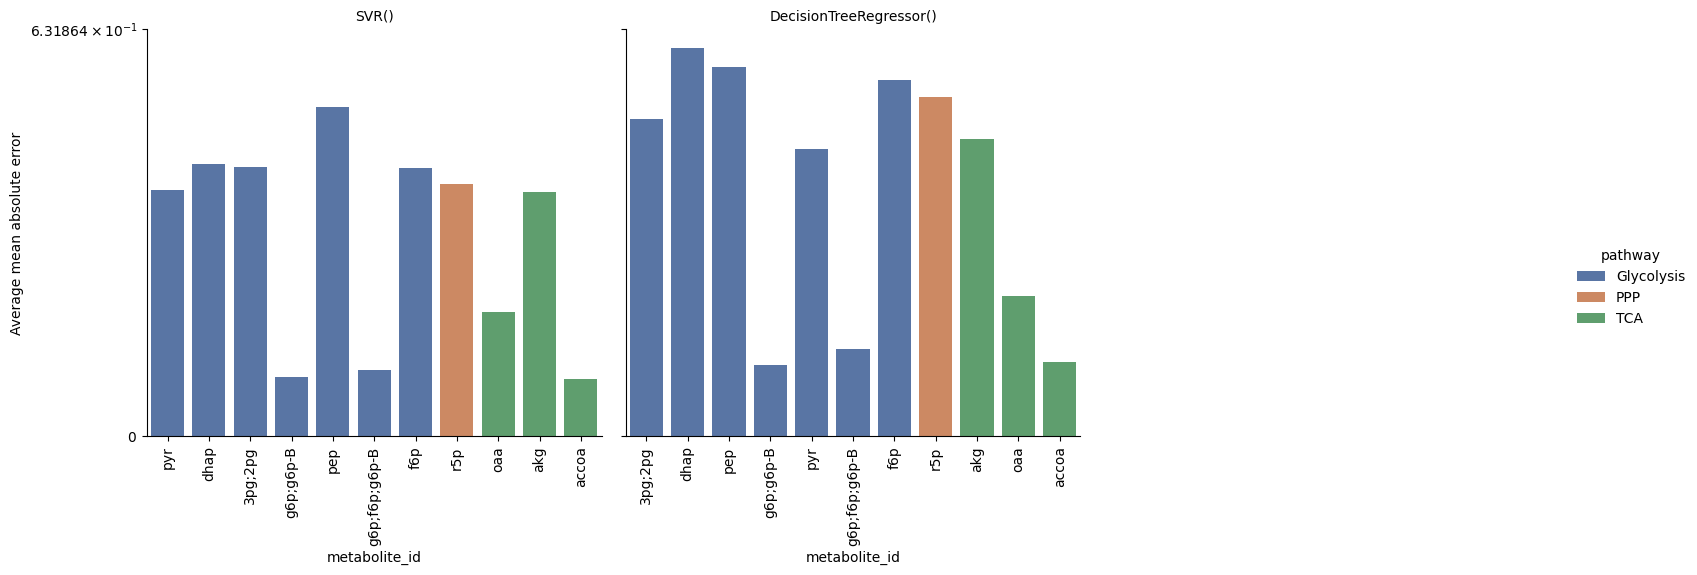

In [7]:
# this can probably be removed
_df = df.reset_index().dropna(axis=0, subset='mean')
best_avarage_models = _df[['regressor', 'params_fmt', 'mean']] \
    .groupby(by=['regressor', 'params_fmt']) \
    .mean('mean') \
    .groupby(by=['regressor']) \
    .idxmin()['mean'].map(lambda x: x[1]).values

g = sns.catplot(
    x='metabolite_id',
    y='mean',
    hue='pathway',
    col='regressor',
    col_wrap=3,
    sharey=True,
    sharex=False,
    kind='bar',
    data=df[df['params_fmt'].isin(best_avarage_models)].sort_values('pathway'),
    dodge=False,
    palette='deep',
    # legend=False,
)
g.set(yscale='symlog')
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
g.set(ylabel='Average mean absolute error')
plt.show()

In [32]:
test_df = pd.read_csv(
    f'{dir}/best_model_performance.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
test_df

,metabolite_id,r2,official_name,kegg_id,pathway,method,Order
0,g6p;g6p-B,0.797115,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
0,g6p;f6p;g6p-B,0.135926,D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10
0,f6p,-0.189029,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
0,dhap,-0.337331,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
0,3pg;2pg,0.168729,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11
0,pep,0.127875,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7
0,pyr,-0.254387,Pyruvate,C00022,Glycolysis,TCA,8
0,r5p,-0.329475,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
0,accoa,0.367829,Acetyl-CoA,C00024,TCA,TCA,1
0,akg,-0.439193,2-Oxoglutarate,C00026,TCA,TCA,4


In [33]:
test_pred_df = pd.read_json(
    f'{dir}/best_model_prediction_performance.json'
)
test_pred_df = test_pred_df.T.reset_index().set_axis(['metabolite_id', 'y_true', 'y_pred'], axis=1) \
    .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
    .explode(['y_true', 'y_pred'])
test_pred_df

,metabolite_id,y_true,y_pred,official_name,kegg_id,pathway,method,Order
0,g6p;g6p-B,0.566822,0.487006,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
0,g6p;g6p-B,-0.073853,0.148183,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
0,g6p;g6p-B,-0.050805,0.187725,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
0,g6p;g6p-B,0.222569,0.101793,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9
1,g6p;f6p;g6p-B,-0.265582,0.038086,D-Glucose 6-phosphate;D-Fructose 6-phosphate;b...,C00092;C00085;C01172,Glycolysis,TCA,10
...,...,...,...,...,...,...,...,...
9,akg,0.597181,0.056967,2-Oxoglutarate,C00026,TCA,TCA,4
10,oaa,-0.053197,-0.187586,Oxaloacetate,C00036,TCA,TCA,8
10,oaa,-0.006942,0.076901,Oxaloacetate,C00036,TCA,TCA,8
10,oaa,-0.148269,0.158807,Oxaloacetate,C00036,TCA,TCA,8


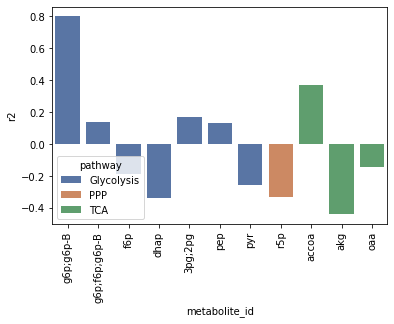

In [34]:
_df = test_df.sort_values('pathway')
g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='r2',
    hue='pathway',
    dodge=False,
    palette='deep',
)
# g.set(yscale='symlog')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

(-1.5, 1.5)

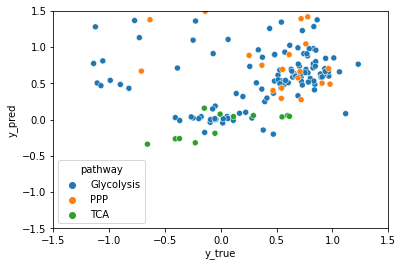

In [36]:
_df = test_pred_df.sort_values('pathway')
g = sns.scatterplot(
    data=_df,
    x='y_true',
    y='y_pred',
    hue='pathway',
)

g.axes.set_xlim([-1.5, 1.5])
g.axes.set_ylim([-1.5, 1.5])

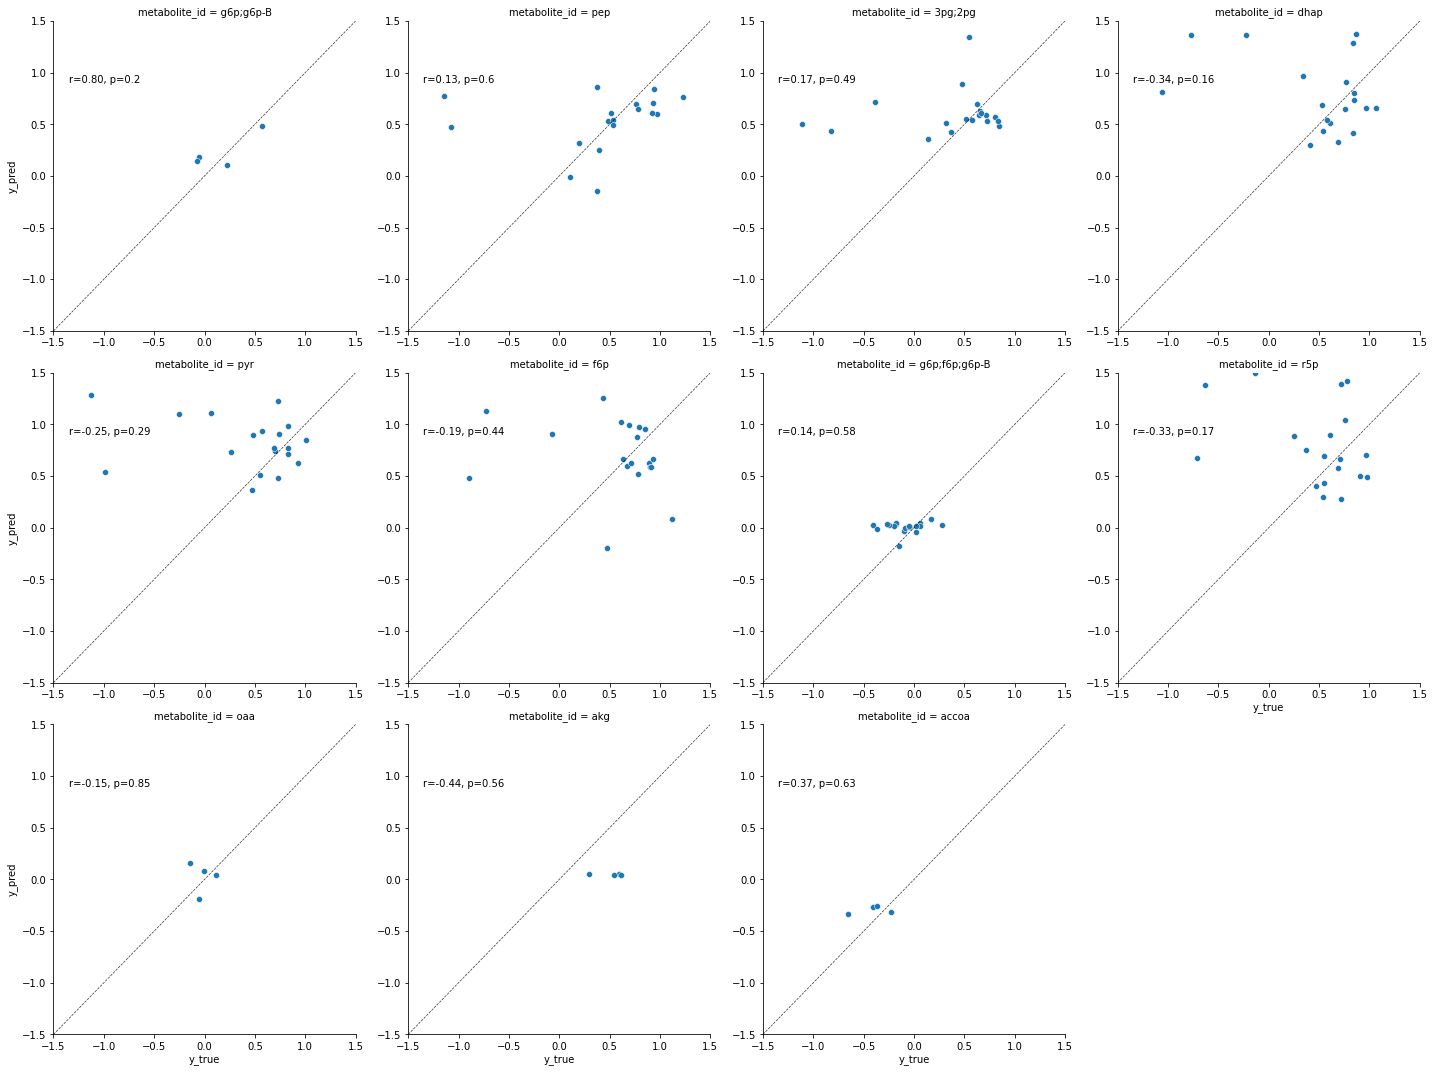

In [38]:
_df = test_pred_df.sort_values('pathway')
rel = sns.relplot(
    data=_df,
    x="y_true",
    y="y_pred",
    kind="scatter",
    col="metabolite_id",
    col_wrap=4,
    facet_kws={'sharey': False, 'sharex': False}
)
for ax in rel.fig.axes:
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])

for ax in rel.fig.axes:
    ax.plot(axes_limits, axes_limits, ls='--', c='black', alpha=0.8, lw=0.7)

for ax, metabolite_id in zip(rel.fig.axes, _df['metabolite_id'].unique()):
    _cdf = _df[_df['metabolite_id'] == metabolite_id]
    r, p = pearsonr(_cdf['y_true'], _cdf['y_pred'])
    ax.text(
        .05, .8, 
        f'r={r:.2f}, p={p:.2g}',
        transform=ax.transAxes
    )

## Experiments simple baseline (TIER 1)

In [14]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_simple_baseline"
paths = glob.glob(dir + "/*.csv")

In [15]:
metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])
df.columns = df.columns.map(lambda name: rename(name))
df['regressor'] = df['regressor'].replace(to_replace=r'^DecisionTreeRegressor.*', value="DecisionTreeRegressor()", regex=True)
df['mean'] = -1 * df['mean']
df['std'] = -1 * df['std']
df['regressor'].replace(to_replace=r'^DecisionTreeRegressor.*', value="DecisionTreeRegressor()", regex=True).unique()

df['params_fmt'] = df['params'].map(lambda param: fmt(param))
df = df[df['params_fmt'] != "-"]

df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
# filter depth none 
df = df[(df['regressor'] == 'DecisionTreeRegressor()') & (df['regressor__max_depth'] > 0) | (df['regressor'] != 'DecisionTreeRegressor()')]
df

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,regressor,regressor__alpha,param_transformer,regressor__criterion,regressor__max_depth,...,mean,std,rank,metabolite_id,params_fmt,official_name,kegg_id,pathway,method,Order
0,0,0.011982,0.002254,0.000000,0.000000,GammaRegressor(),0.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,22.0,oaa,alpha: 0\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
1,1,0.014943,0.003624,0.000000,0.000000,GammaRegressor(),1.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,21.0,oaa,alpha: 1\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
2,2,0.016312,0.002515,0.000000,0.000000,GammaRegressor(),10.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,20.0,oaa,alpha: 10\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
4,4,0.025894,0.008019,0.008388,0.004431,DecisionTreeRegressor(),NaN,NaN,squared_error,5.0,...,0.065993,-0.001550,13.0,oaa,criterion: squared_error\nmax_depth: 5,Oxaloacetate,C00036,TCA,TCA,8
5,5,0.035504,0.011924,0.009493,0.003807,DecisionTreeRegressor(),NaN,NaN,squared_error,10.0,...,0.018407,-0.000440,8.0,oaa,criterion: squared_error\nmax_depth: 10,Oxaloacetate,C00036,TCA,TCA,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,17,8.631664,0.778944,0.004668,0.001026,ElasticNet(),NaN,NaN,NaN,NaN,...,0.357913,-0.006923,14.0,accoa,l1_ratio: 0,Acetyl-CoA,C00024,TCA,TCA,1
18,18,0.028887,0.006906,0.008263,0.002747,ElasticNet(),NaN,NaN,NaN,NaN,...,0.381151,-0.007266,15.0,accoa,l1_ratio: 0.25,Acetyl-CoA,C00024,TCA,TCA,1
19,19,0.029481,0.005639,0.008188,0.002243,ElasticNet(),NaN,NaN,NaN,NaN,...,0.381151,-0.007266,15.0,accoa,l1_ratio: 0.5,Acetyl-CoA,C00024,TCA,TCA,1
20,20,0.029464,0.004176,0.008000,0.001555,ElasticNet(),NaN,NaN,NaN,NaN,...,0.381151,-0.007266,15.0,accoa,l1_ratio: 0.75,Acetyl-CoA,C00024,TCA,TCA,1


In [16]:
df[(df['regressor'] == 'DecisionTreeRegressor()') & (df['regressor__max_depth'] > 0) | (df['regressor'] != 'DecisionTreeRegressor()')]

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,regressor,regressor__alpha,param_transformer,regressor__criterion,regressor__max_depth,...,mean,std,rank,metabolite_id,params_fmt,official_name,kegg_id,pathway,method,Order
0,0,0.011982,0.002254,0.000000,0.000000,GammaRegressor(),0.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,22.0,oaa,alpha: 0\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
1,1,0.014943,0.003624,0.000000,0.000000,GammaRegressor(),1.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,21.0,oaa,alpha: 1\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
2,2,0.016312,0.002515,0.000000,0.000000,GammaRegressor(),10.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,20.0,oaa,alpha: 10\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
4,4,0.025894,0.008019,0.008388,0.004431,DecisionTreeRegressor(),NaN,NaN,squared_error,5.0,...,0.065993,-0.001550,13.0,oaa,criterion: squared_error\nmax_depth: 5,Oxaloacetate,C00036,TCA,TCA,8
5,5,0.035504,0.011924,0.009493,0.003807,DecisionTreeRegressor(),NaN,NaN,squared_error,10.0,...,0.018407,-0.000440,8.0,oaa,criterion: squared_error\nmax_depth: 10,Oxaloacetate,C00036,TCA,TCA,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,17,8.631664,0.778944,0.004668,0.001026,ElasticNet(),NaN,NaN,NaN,NaN,...,0.357913,-0.006923,14.0,accoa,l1_ratio: 0,Acetyl-CoA,C00024,TCA,TCA,1
18,18,0.028887,0.006906,0.008263,0.002747,ElasticNet(),NaN,NaN,NaN,NaN,...,0.381151,-0.007266,15.0,accoa,l1_ratio: 0.25,Acetyl-CoA,C00024,TCA,TCA,1
19,19,0.029481,0.005639,0.008188,0.002243,ElasticNet(),NaN,NaN,NaN,NaN,...,0.381151,-0.007266,15.0,accoa,l1_ratio: 0.5,Acetyl-CoA,C00024,TCA,TCA,1
20,20,0.029464,0.004176,0.008000,0.001555,ElasticNet(),NaN,NaN,NaN,NaN,...,0.381151,-0.007266,15.0,accoa,l1_ratio: 0.75,Acetyl-CoA,C00024,TCA,TCA,1


In [17]:
test_df = pd.read_csv(
    './data/results/experiment_simple_baseline/best_model_performance.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
test_df

,metabolite_id,r2,official_name,kegg_id,pathway,method,Order
metabolite_id,,,,,,,


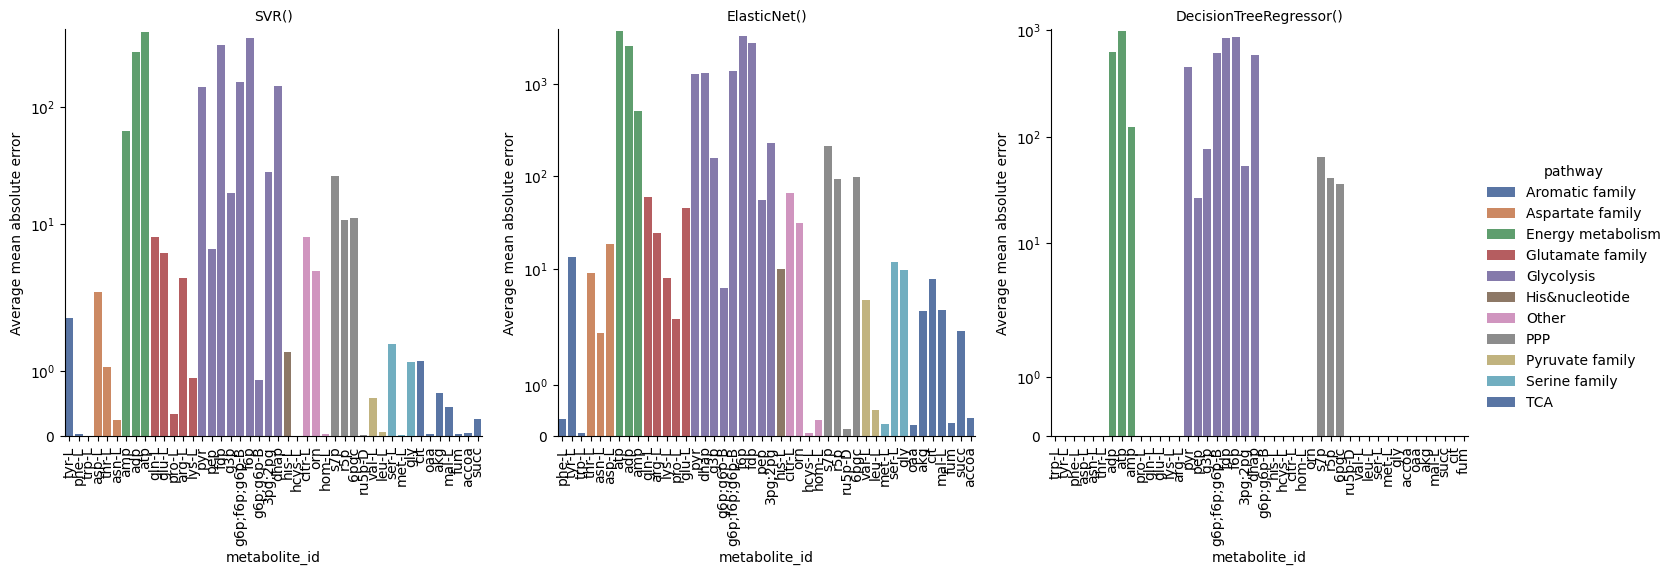

In [18]:
_df = df.reset_index().dropna(axis=0, subset='mean')
best_avarage_models = _df[['regressor', 'params_fmt', 'mean']] \
    .groupby(by=['regressor', 'params_fmt']) \
    .mean('mean') \
    .groupby(by=['regressor']) \
    .idxmin()['mean'].map(lambda x: x[1]).values

g = sns.catplot(
    x='metabolite_id',
    y='mean',
    hue='pathway',
    col='regressor',
    col_wrap=3,
    sharey=False,
    sharex=False,
    kind='bar',
    data=df[df['params_fmt'].isin(best_avarage_models)].sort_values('pathway'),
    dodge=False,
    palette='deep',
    # legend=False,
)
g.set(yscale='symlog')
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
g.set(ylabel='Average mean absolute error')
plt.show()

(132, 73)
(352, 73)
(176, 73)
(220, 73)


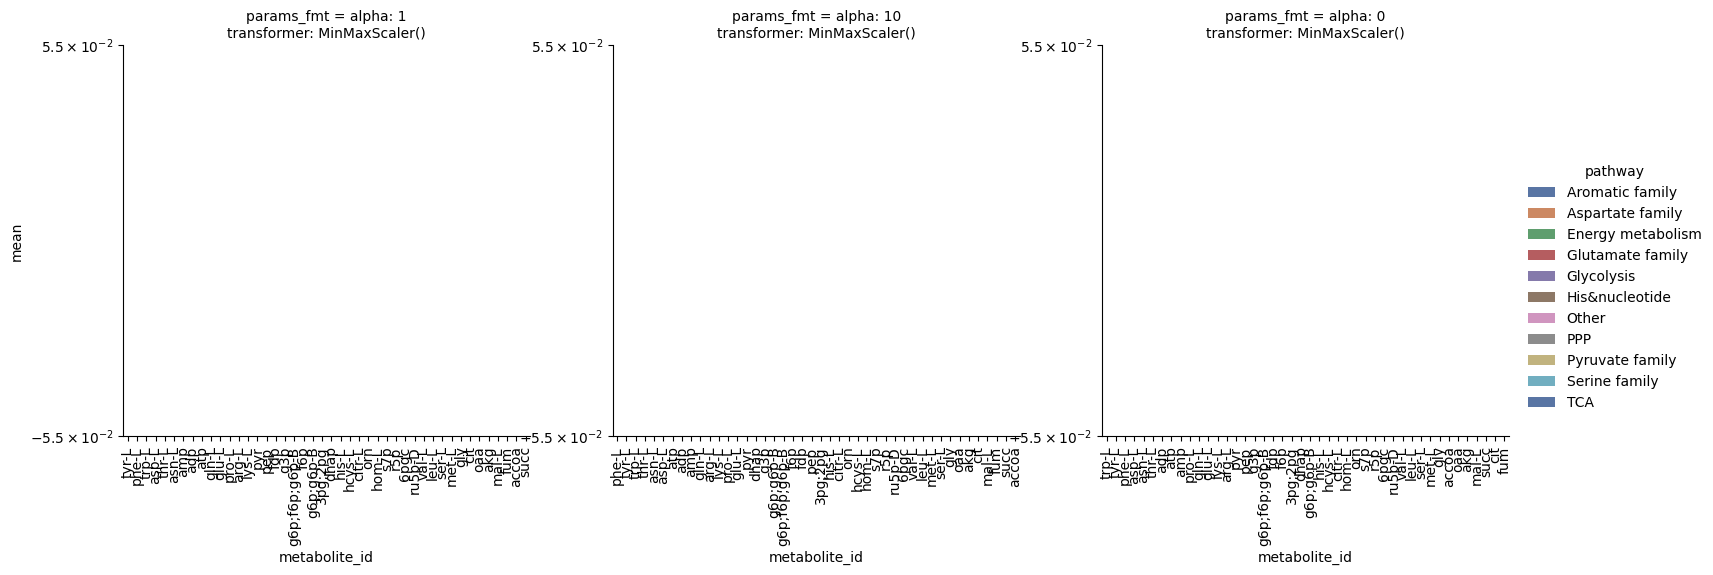

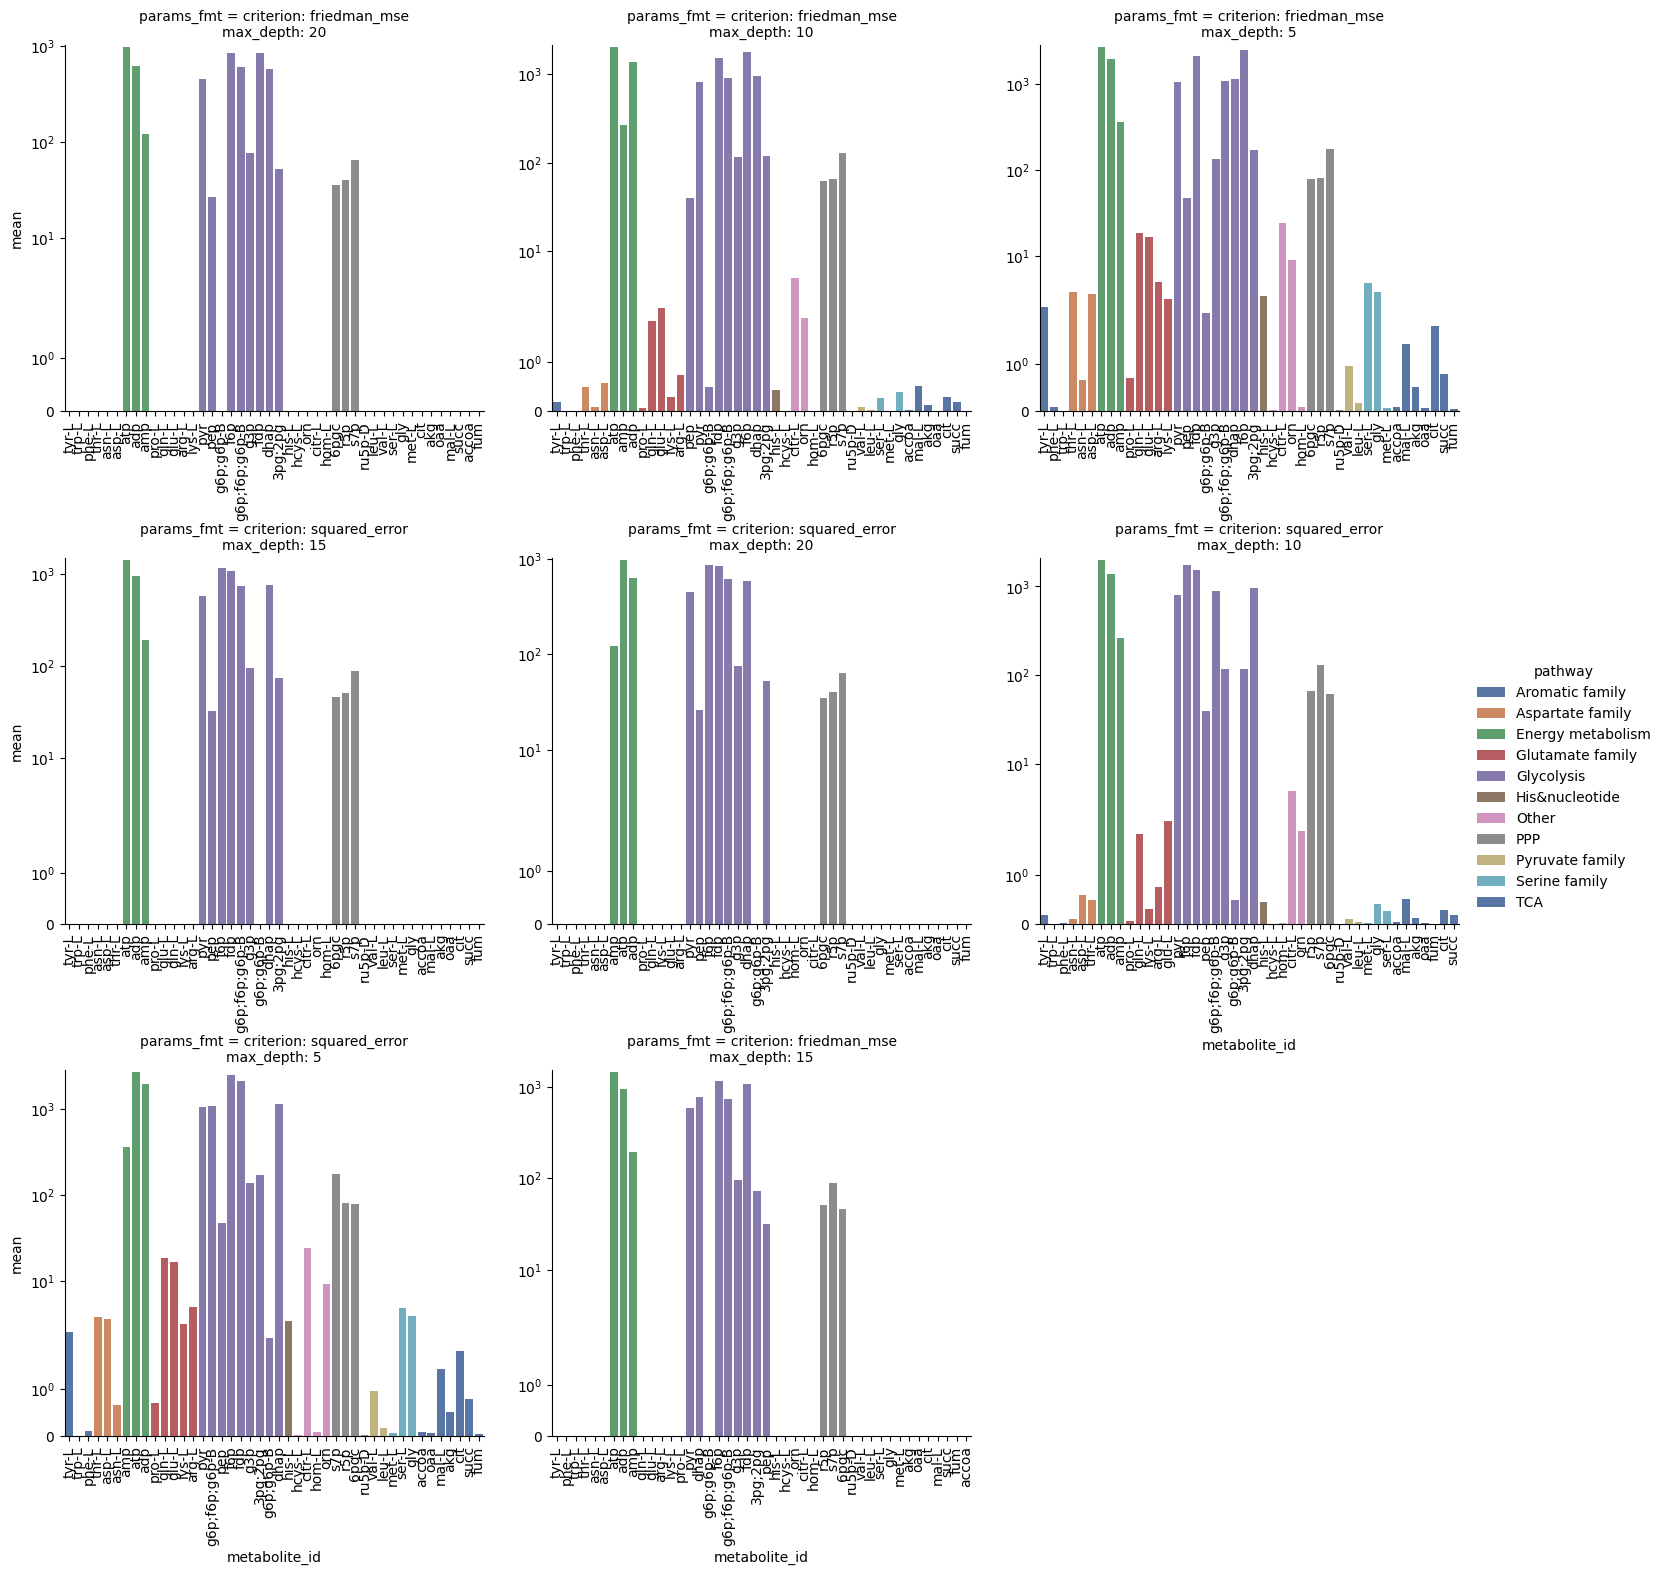

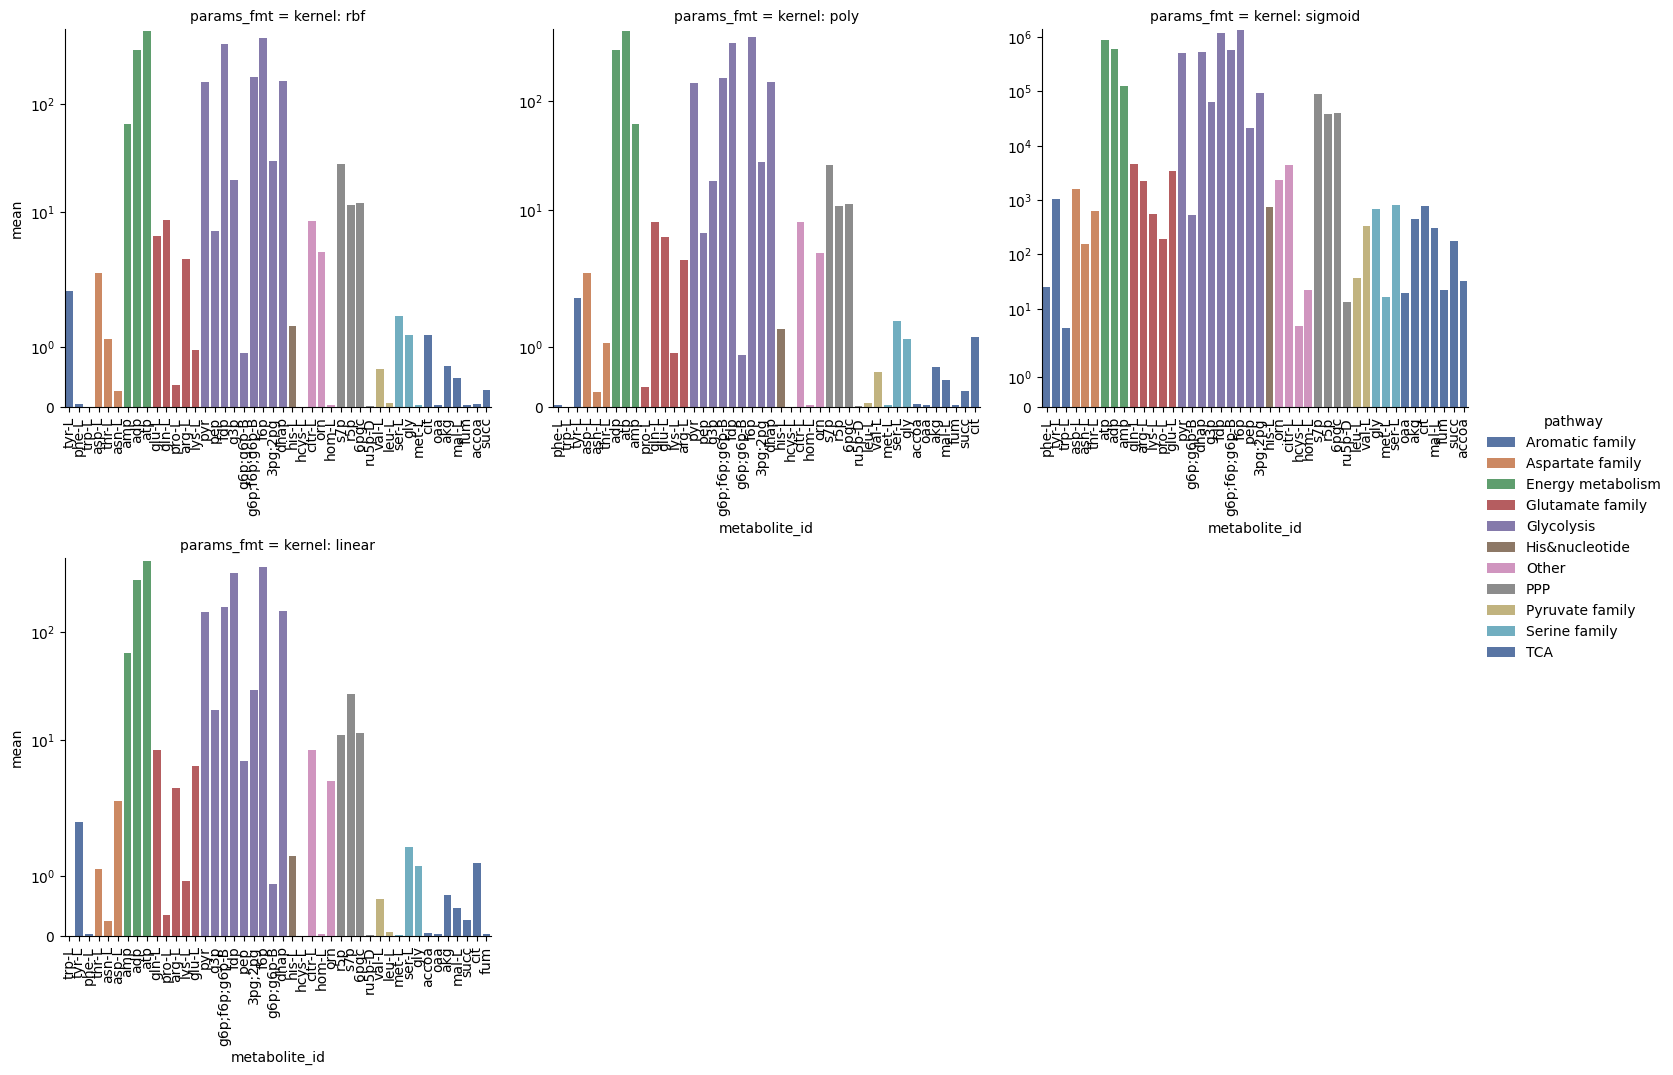

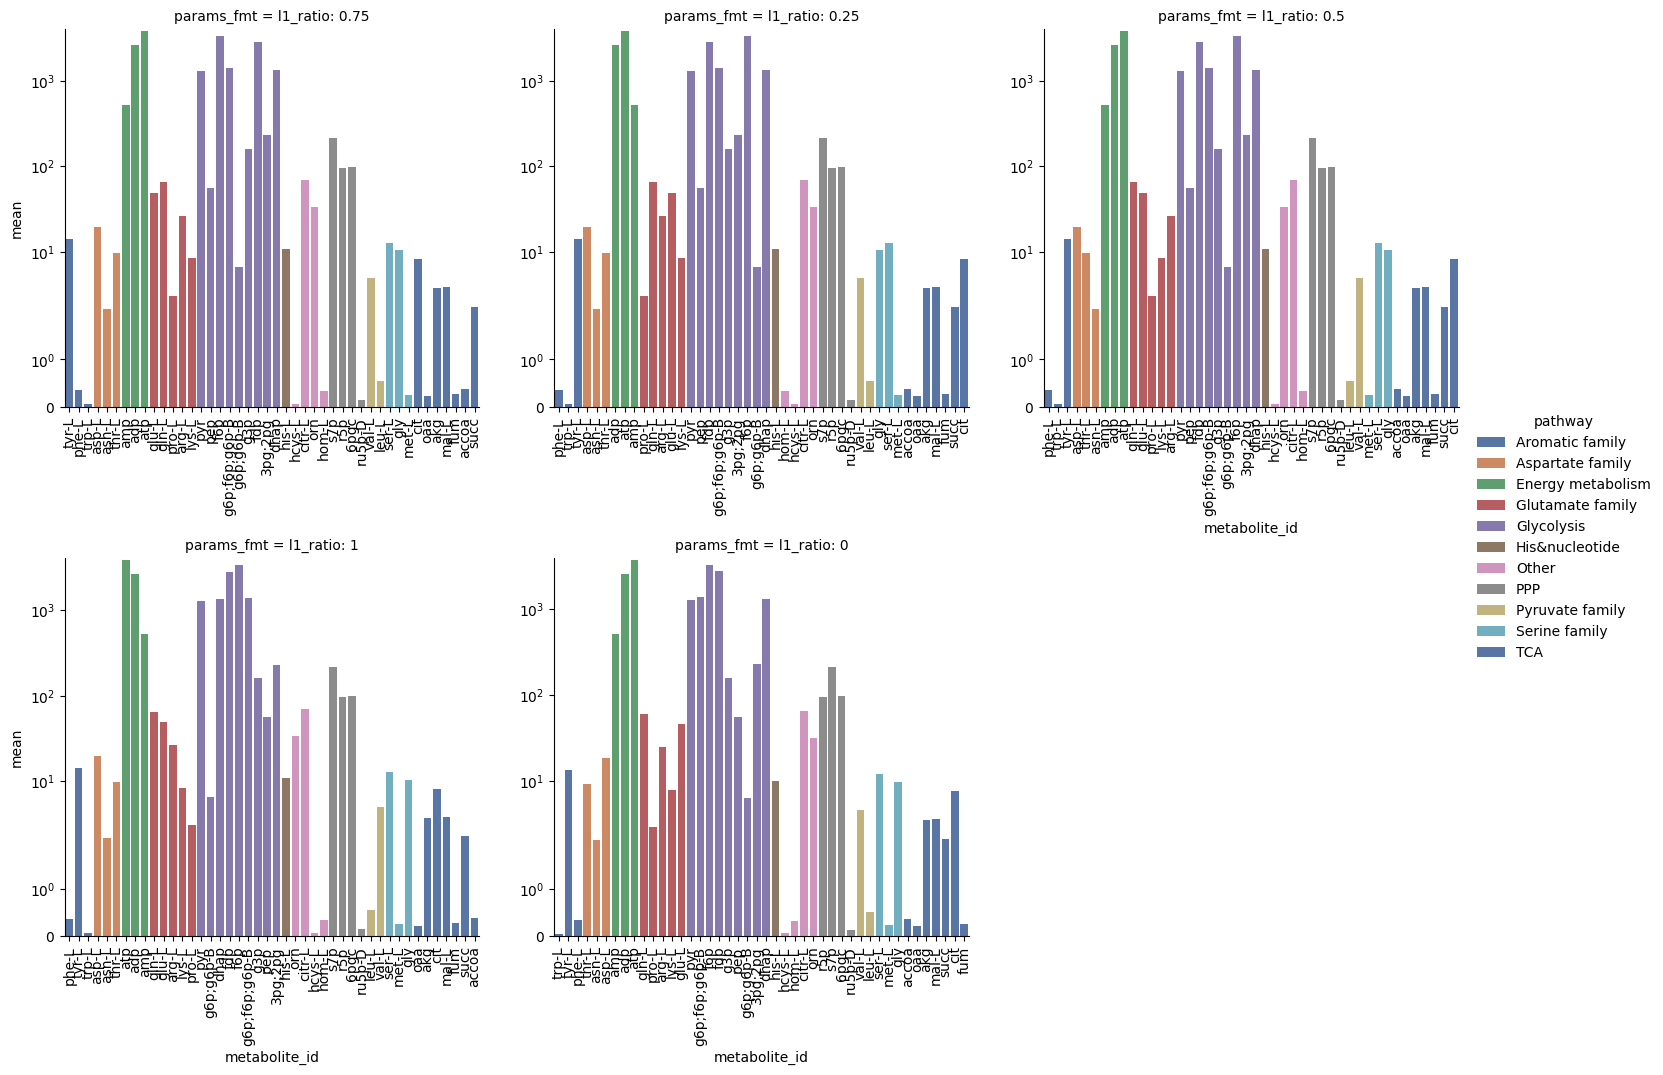

In [19]:
for reggressor in df['regressor'].unique():
    _df = df[df['regressor'] == reggressor].sort_values('pathway')
    print(_df.shape)
    g = sns.catplot(
        x='metabolite_id',
        y='mean',
        hue='pathway',
        col='params_fmt',
        col_wrap=3,
        sharey=False,
        sharex=False,
        kind='bar',
        data=_df,
        dodge=False,
        palette='deep',
        # legend=False,
    )

    g.set(yscale='symlog')
    g.set_xticklabels(rotation=90)
    plt.subplots_adjust(hspace=0.4)
    # plt.legend(bbox_to_anchor=(0.8, 0.5), loc='center left',)
    # plt.tight_layout()

In [20]:
idx = df.groupby(by='metabolite_id')['rank'].transform(min) == df['rank']
best_models = df[idx]
best_models['params_fmt'].shape

(44,)

In [21]:
_df = test_df.sort_values('pathway')
g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='r2',
    hue='pathway',
    dodge=False,
    palette='deep',
)
# g.set(yscale='symlog')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

ValueError: min() arg is an empty sequence